Vorhersage des Modells: setosa

Erklärung als Text:
[('petal length (cm) <= 1.50', -0.18981231843910829), ('0.30 < petal width (cm) <= 1.30', 0.17385316992250704), ('5.10 < sepal length (cm) <= 5.75', 0.042634960420207695), ('3.00 < sepal width (cm) <= 3.40', 0.016483038950881195)]


/home/karl-/git/liquidstatemachines/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/karl-/git/liquidstatemachines/venv/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/karl-/git/liquidstatemachines/venv/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))

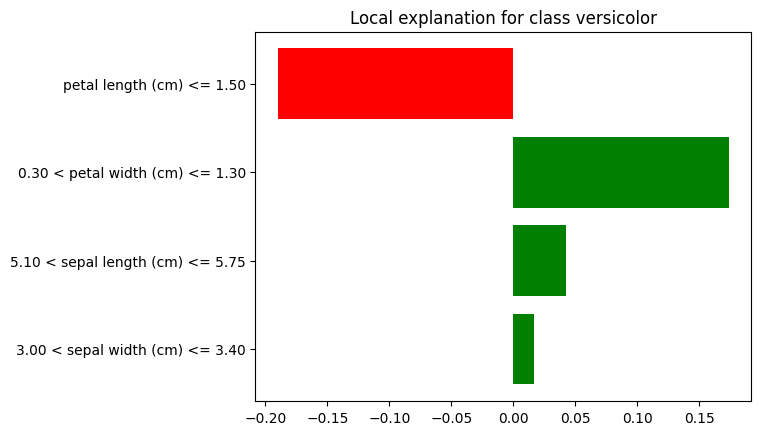

In [19]:
# LIME Explainable AI Tutorial
# ============================
# Dieses Notebook zeigt, wie man LIME verwendet, um Vorhersagen eines Machine Learning Modells zu erklären.

# ---
# 1. Einführung
# LIME ist eine Methode, die für ein beliebiges "Black-Box"-Modell lokal interpretable Erklärungen liefert.
# Es erzeugt künstliche, leicht veränderte Datenpunkte in der Umgebung eines bestimmten Beispiels
# und passt ein einfaches, erklärbares Modell (z. B. lineare Regression) darauf an.
# Dadurch kann man sehen, welche Features zu dieser spezifischen Vorhersage beigetragen haben.
# ---

# ## 2. Installation
# Falls LIME nicht installiert ist, kann man es mit folgendem Befehl installieren:
# !pip install lime

# ## 3. Imports
from IPython.display import display, HTML

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lime.lime_tabular import LimeTabularExplainer

# ## 4. Datensatz laden
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ## 5. Modell trainieren
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# ## 6. LIME-Tabular-Explainer einrichten
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=data.feature_names,
    class_names=data.target_names,
    mode='classification'
)

# ## 7. Beispielvorhersage erklären
# Wir nehmen einen zufälligen Testpunkt
i = 5
instance = X_test.iloc[i]
print("Vorhersage des Modells:", data.target_names[model.predict([instance])[0]])

# Erklärung erzeugen
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=model.predict_proba
)

# ## 8. Erklärung anzeigen

# Alternativ als Text
print("\nErklärung als Text:")
print(exp.as_list())

# oder als Matplotlib-Plot
import matplotlib.pyplot as plt
fig = exp.as_pyplot_figure()
plt.show()
# ## 9. Interpretation
# Die Ausgaben zeigen, welche Features das Modell für diese eine Vorhersage am meisten beeinflusst haben.
# Positive Werte bedeuten einen Beitrag zur vorhergesagten Klasse, negative Werte ziehen den Score in Richtung einer anderen Klasse.


Top-3 Predictions:
tiger cat 0.36846381425857544
Egyptian cat 0.34478697180747986
tabby 0.16549387574195862


  0%|          | 0/1000 [00:00<?, ?it/s]

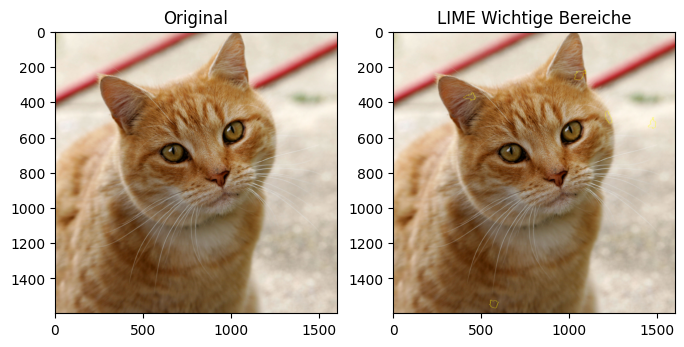

In [26]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import requests
from io import BytesIO

# Modell laden
model = models.resnet18(pretrained=True)
model.eval()

# Bild von URL laden
url = "https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('RGB')

# Transformation für ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Originalbild für Anzeige
img_tensor = transform(img).unsqueeze(0)  # Batch-Dimension

# Vorhersage
with torch.no_grad():
    output = model(img_tensor)
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)

# ImageNet-Klassen laden
imagenet_classes = []
url_classes = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
response = requests.get(url_classes)
imagenet_classes = [s.strip() for s in response.text.splitlines()]

print("Top-3 Predictions:")
for i in range(3):
    print(imagenet_classes[top5_catid[i]], top5_prob[i].item())

# LIME Image Explainer
def batch_predict(images):
    model.eval()
    batch = torch.stack([transform(Image.fromarray(img.astype('uint8'))) for img in images], dim=0)
    with torch.no_grad():
        logits = model(batch)
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.numpy()

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    np.array(img),
    classifier_fn=batch_predict,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Maske & Segmente
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# Visualisierung
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Wichtige Bereiche")
plt.show()


[('0.00 < t-1 <= 0.70', 0.4792691395830483), ('t-5 > 0.70', -0.04663245639792001), ('0.00 < t-2 <= 0.70', 0.02739370040280526), ('0.00 < t-3 <= 0.70', 0.019815012281347376), ('t-4 > 0.70', -0.0025016360122501547)]


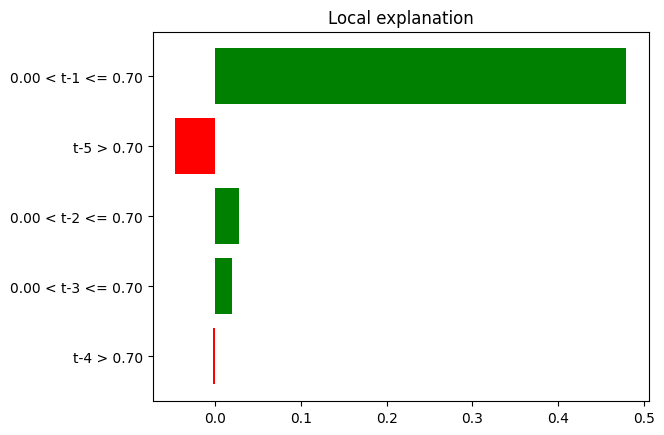

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from lime.lime_tabular import LimeTabularExplainer

# Synthetische Zeitreihe
np.random.seed(42)
t = np.arange(100)
y = np.sin(0.2*t) + 0.1*np.random.randn(100)

# Features: Sliding Window der Länge 5
X = np.array([y[i:i+5] for i in range(len(y)-5)])
y_target = y[5:]

# Modell trainieren
model = RandomForestRegressor()
model.fit(X, y_target)

# LIME Explainer
explainer = LimeTabularExplainer(
    X,
    feature_names=[f't-{i}' for i in range(5,0,-1)],
    mode='regression'
)

# Erklärung für einen Zeitpunkt
i = 10
exp = explainer.explain_instance(
    X[i],
    model.predict
)

print(exp.as_list())

# Visualisierung
exp.as_pyplot_figure()
plt.show()
